# In this notebook code for image preprocessing, raining and testing(image by image and overall accuracy) of UE4 image will be developed

In [5]:
import numpy as np
from skimage import io, color, exposure, transform
from skimage.color import rgb2gray
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split  #it came from update scikit learn. https://stackoverflow.com/questions/40704484/importerror-no-module-named-model-selection
import os
import glob
import h5py
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.pooling import MaxPooling2D

from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib.pylab import rcParams

#import keras

NUM_CLASSES = 16 # change it with respect to the desired class
IMG_SIZE = 224 # change it if it desired
IMG_depth = 3 # for RGB 3, for B&W it will be 1
from keras.applications import VGG16

In [7]:
h5py.__version__

'2.9.0'

# Image preprocessing function

In [3]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,centre[1]-min_side//2:centre[1]+min_side//2,:]
#    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img

def get_class(img_path):
    return int(img_path.split('/')[-2])
#     return str(img_path.split('/')[-2]) # returning the folder name. If use -1 that means image name. consider the img_path.

In [15]:
imgs = []
labels = []
root_dir = '/home/atif/machine_learning_stuff/ml_image/train_image_AI/'
#path='/home/atif/training_by_several_learning_process/flower_photos/00000/'

#all_img_paths = glob.glob(path+ '5547758_eea9edfd54_n_000.jpg')

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.png')) #I have done the training with .png format image. If another type of image will come 
                                                                                    #them .png will be changed by that extension
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    try:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        imgs.append(img)
        labels.append(label)

        if len(imgs)%1200 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
            #print("get it 2")
    except (IOError, OSError):
        print('missed', img_path)
        pass

Processed 1200/57600
Processed 2400/57600
Processed 3600/57600
Processed 4800/57600
Processed 6000/57600
Processed 7200/57600
Processed 8400/57600
Processed 9600/57600
Processed 10800/57600
Processed 12000/57600
Processed 13200/57600
Processed 14400/57600
Processed 15600/57600
Processed 16800/57600
Processed 18000/57600
Processed 19200/57600
Processed 20400/57600
Processed 21600/57600
Processed 22800/57600
Processed 24000/57600
Processed 25200/57600
Processed 26400/57600
Processed 27600/57600
Processed 28800/57600
Processed 30000/57600
Processed 31200/57600
Processed 32400/57600
Processed 33600/57600
Processed 34800/57600
Processed 36000/57600
Processed 37200/57600
Processed 38400/57600
Processed 39600/57600
Processed 40800/57600
Processed 42000/57600
Processed 43200/57600
Processed 44400/57600
Processed 45600/57600
Processed 46800/57600
Processed 48000/57600
Processed 49200/57600
Processed 50400/57600
Processed 51600/57600
Processed 52800/57600
Processed 54000/57600
Processed 55200/57

In [23]:
X = np.array(imgs, dtype='float32') #Keeping the image as an array
X = X.reshape(len(imgs),IMG_depth,IMG_SIZE,IMG_SIZE) # write (IMG_SIZE,IMG_SIZE,1 if you want channel last; 1= grayscale;3=RGB)
# Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
Y = keras.utils.to_categorical(labels, NUM_CLASSES)

print('X shape: ', X.shape,' type: ',type(X))
print('Y shape: ', Y.shape,' type: ',type(Y))

X shape:  (57600, 3, 48, 48)  type:  <class 'numpy.ndarray'>
Y shape:  (57600, 16)  type:  <class 'numpy.ndarray'>


# Model declaration

In [26]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 48, 48)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 46, 46)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 23, 23)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 23, 23)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 23, 23)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 21, 21)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 10, 10)        0         
__________

In [28]:
path = '/home/atif/machine_learning_stuff/model_file_keras/'

In [ ]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 100
do_train_model=model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,verbose=2,
          #np.resize(img, (-1, <image shape>)
          callbacks=[LearningRateScheduler(lr_schedule),ModelCheckpoint(path+'test_case_all_image_general_epoch_100.h5', save_best_only=True)])

Train on 46080 samples, validate on 11520 samples
Epoch 1/100
 - 20s - loss: 1.1170 - acc: 0.6208 - val_loss: 0.2543 - val_acc: 0.9203
Epoch 2/100
 - 19s - loss: 0.2219 - acc: 0.9283 - val_loss: 0.1217 - val_acc: 0.9604
Epoch 3/100
 - 19s - loss: 0.1206 - acc: 0.9614 - val_loss: 0.0514 - val_acc: 0.9833
Epoch 4/100
 - 19s - loss: 0.0764 - acc: 0.9752 - val_loss: 0.0342 - val_acc: 0.9879
Epoch 5/100
 - 20s - loss: 0.0547 - acc: 0.9826 - val_loss: 0.0147 - val_acc: 0.9952
Epoch 6/100
 - 20s - loss: 0.0435 - acc: 0.9861 - val_loss: 0.0102 - val_acc: 0.9973
Epoch 7/100
 - 20s - loss: 0.0455 - acc: 0.9862 - val_loss: 0.0188 - val_acc: 0.9941
Epoch 8/100
 - 19s - loss: 0.0311 - acc: 0.9905 - val_loss: 0.0028 - val_acc: 0.9988
Epoch 9/100
 - 19s - loss: 0.0353 - acc: 0.9894 - val_loss: 0.0215 - val_acc: 0.9930
Epoch 10/100
 - 19s - loss: 0.0334 - acc: 0.9893 - val_loss: 0.0044 - val_acc: 0.9988
Epoch 11/100
 - 19s - loss: 0.0101 - acc: 0.9969 - val_loss: 0.0021 - val_acc: 0.9995
Epoch 12/100


# load saved model

In [7]:
from keras.models import load_model
# model = load_model('/home/atif/machine_learning_stuff/model_file_keras/general_2_sep_ep_30_epoch.h5')
model = load_model('/home/atif/machine_learning_stuff/unreal_cv_image/unreal_cv_image_manipulation/classification_UE4_image/trained_model/all_freezed_old.h5')

ResourceExhaustedError: OOM when allocating tensor with shape[25088,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_7_2/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=4223008, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_7_2/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'dense_7_2/random_uniform/RandomUniform', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-542b7baf4832>", line 3, in <module>
    model = load_model('/home/atif/machine_learning_stuff/unreal_cv_image/unreal_cv_image_manipulation/classification_UE4_image/trained_model/all_freezed_old.h5')
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/keras/models.py", line 240, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/keras/models.py", line 314, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/keras/layers/__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/keras/utils/generic_utils.py", line 140, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/keras/models.py", line 1324, in from_config
    model.add(layer)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/keras/models.py", line 489, in add
    output_tensor = layer(self.outputs[0])
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/keras/engine/topology.py", line 576, in __call__
    self.build(input_shapes[0])
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/keras/layers/core.py", line 830, in build
    constraint=self.kernel_constraint)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/keras/engine/topology.py", line 397, in add_weight
    weight = K.variable(initializer(shape),
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/keras/initializers.py", line 212, in __call__
    dtype=dtype, seed=self.seed)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3637, in random_uniform
    dtype=dtype, seed=seed)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 242, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 674, in random_uniform
    name=name)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/atif/tf_gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[25088,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: dense_7_2/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=4223008, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_7_2/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



# Check total accuracy of the model using all test images

In [6]:
import pandas as pd
test = pd.read_csv('/home/atif/machine_learning_stuff/ml_image/test_image_keras_IAI.csv',sep=';')
# test_image_path =  '/home/atif/machine_learning_stuff/ml_image/test_image_crop/'

X_test = []
y_test = []
i = 0
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    print('filename: ',file_name,'\t classId: ',class_id)
    #print('classId: ',class_id)
    img_path = os.path.join('/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/',file_name)
#     img_path = glob.glob(os.path.join(test_image_path, '*/*.jpg'))
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

filename:  denkmit_edelstahk_reiniger (1).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (2).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (3).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (4).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (5).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (6).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (7).jpg 	 classId:  5
filename:  denkmit_Entkalker (1).jpg 	 classId:  7
filename:  denkmit_Entkalker (2).jpg 	 classId:  7
filename:  denkmit_Entkalker (3).jpg 	 classId:  7
filename:  denkmit_Entkalker (4).jpg 	 classId:  7
filename:  denkmit_Entkalker (5).jpg 	 classId:  7
filename:  denkmit_Entkalker (6).jpg 	 classId:  7
filename:  denkmit_geschirrreiniger_REVOLUTION (1).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (2).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (3).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (4).jpg 	 classId

In [7]:
print(img_path)

/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/35_SM_DenkMitEdelstahlReinigerSpray_20_34_90_60_lit_cropped.jpg


In [8]:
y_test

array([ 5,  5,  5,  5,  5,  5,  5,  7,  7,  7,  7,  7,  7, 10, 10, 10, 10,
       10, 10,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8, 11, 11, 11, 11,
       11,  3,  9, 12, 14,  3,  3,  3,  2,  2,  2,  2,  0,  0,  0,  0,  0,
        1,  1,  1,  1,  1,  1,  3,  3, 14, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 15, 15, 15, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14,
        4,  4,  6,  6])

# finding accuracy

In [20]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.6853932584269663


In [21]:
y_pred

array([ 5,  5,  5, 11,  7, 11,  5,  7,  7, 15,  7,  7,  7, 11,  8,  9, 15,
       11, 11,  9, 11, 11,  9,  9, 11, 13,  8,  8,  8,  8, 11, 11, 11, 11,
       11,  3,  9,  3, 14,  3,  3,  3,  4,  2,  2,  2,  0,  0,  0,  0,  0,
        1,  1,  1,  1,  1,  1,  3,  3, 14, 13, 13, 14, 13, 15, 15, 15, 15,
       15, 15, 15, 15,  3,  0,  3,  3, 13, 13,  9, 14, 13, 11, 13, 13, 14,
        4,  4,  6,  6])

# check true vs true/false result

In [22]:
count =0
right_count=0
wrong_count=0
for i,j in enumerate(y_test):
    count +=1
    if j == y_pred[i]:
        right_count+=1
#         print(count,'-'*5,j,'-'*5,y_pred[i])
        
    else:
#         pass
        wrong_count+=1
        print(count,'°'*40,j,'-'*5,y_pred[i])
print('total: ',count)
print('right_count: ',right_count)
print('wrong_count',wrong_count)

4 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 11
5 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 7
6 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 11
10 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 7 ----- 15
14 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 10 ----- 11
15 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 10 ----- 8
16 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 10 ----- 9
17 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 10 ----- 15
18 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 10 ----- 11
19 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 10 ----- 11
21 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 9 ----- 11
22 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 9 ----- 11
25 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 8 ----- 11
26 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 8 ----- 13
38 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 12 ----- 3
43 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 2 ----- 4
61 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 14 ----- 13
62 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 14 ----- 13
64 °°°°°°

# do accuracy calculationfrom scratch

In [23]:
accuracy = (right_count/y_pred.shape[0])*100
print(accuracy)

68.53932584269663


# confusion matrix calculation

In [24]:
from sklearn.metrics import confusion_matrix
results = confusion_matrix(y_test, y_pred)
print(results)
print(type(results))
print(results.shape)

[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 1 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 4 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 3 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [1 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 0 3 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 5 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8]]
<class 'numpy.ndarray'>
(16, 16)


# confusion matrix visualization with seaborn heatmap

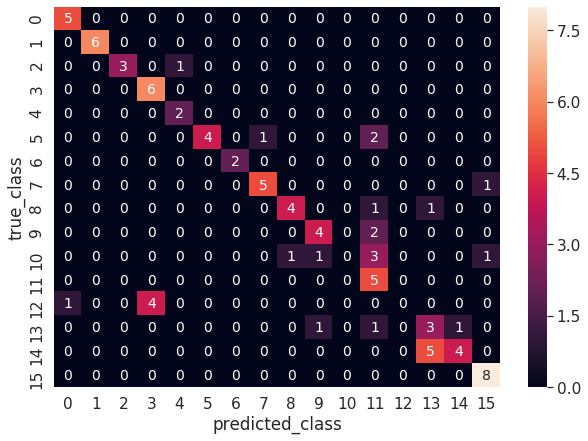

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(results, range(16),
                  range(16))
plt.figure(figsize = (10,7))
plt.tight_layout()
sn.set(font_scale=1.4)#for label size

ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 14},xticklabels=True, yticklabels=True)# font size
ax.set(xlabel='predicted_class', ylabel='true_class')
ax.set_ylim(16)
figure = ax.get_figure()    
figure.savefig('2_sep_ax_conf.png', dpi=400)


# confusion matrix visualization with matplotlib

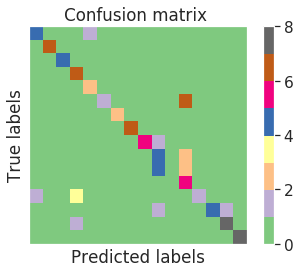

In [26]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Accent)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
# plt.xticks(y_pred)
plt.yticks([], [])
# plt.xticks(y_test)
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

# check class image by image

In [ ]:
import glob

test_image_path = r'/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/'

my_name = ['SM_CalgonitFinish_2','SM_CalgonitFinishKlarspueler_5','SM_CalgonitFinishMaschinenpfleger_8','SM_CalgonitFinishSpezialSalz_11',
           'SM_CalgonitFinishVorratspack_14','SM_DenkMitEdelstahlreiniger_17','SM_DenkMitEdelstahlReinigerSpray_20','SM_DenkMitEntkalker_23',
           'SM_DenkMitGeschirrReiniger_26','SM_DenkMitGeschirrReinigerClassic_29','SM_DenkMitGeschirrReinigerEvo_32','SM_DenkMitGeschirrReinigerNature_35',
           'SM_DenkMitHygieneAllzweckreiniger_38','SM_DenkMitMaschinenpfleger_41','SM_DenkMitSpezialsalz_44','SM_SomatClassic_53']

img_path = glob.glob(test_image_path+ '/*.jpg')
for image in img_path:
    X_test=[]
    X_test.append(preprocess_img(io.imread(image)))
    X_test = np.array(X_test)
#     plt.imshow(X_test)
    X_test = X_test.reshape(len(X_test),3,IMG_SIZE,IMG_SIZE)
    
    print('image name is: ',image)
    predicted_class = model.predict_classes(X_test)
    print("predicted class: ",predicted_class)
#     print('type-of predicted calss: ', type(predicted_class))
    print('class name is: ',my_name[predicted_class[0]])
    
#     probability = model.predict_proba(X_test)
#     print("probability: ",probability)
    print('\n')

# training with data augmentation

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.,)

datagen.fit(X_train)

In [19]:
model_augmentation = cnn_model()
# let's train the model using SGD + momentum (how original).
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model_augmentation.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

In [ ]:
nb_epoch = 30
batch_size = 32
model_augmentation.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0],
                            epochs=nb_epoch,
                            validation_data=(X_val, Y_val),
                            callbacks=[LearningRateScheduler(lr_schedule),
                                       ModelCheckpoint(path+'model_augmentation_30_epoch_27_aug.h5',save_best_only=True)]
                           )

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [9]:
import matplotlib
matplotlib.__version__

'3.1.1'